# Plot results

We plo colony growth rate of Staph-Pseudomonas co-cultures on agar-pads and analyze spatial growth dependence 

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#path handling
import pathlib

--- 

## 1. Load data

In [135]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
exp_name = "20230411"

#read data
csv_name = path_data_files / f"{exp_name}_all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)

#set settings
dt_frames = 5/60 #time between frames in hours 

---

## 2. Pre-process data 

We do some clean up by:

- removing PA data from data frame, as we only care about SA growth. 
- removing untracked colonies

Also we create a unique id for each colony by combining strain with position number and with colony_id

Finally, to compare growth between colonies we first normalize colony area to 1 in the first frame and than take the log of this (colony grow exponentially in area)

We then plot the log normalized area as function of time.

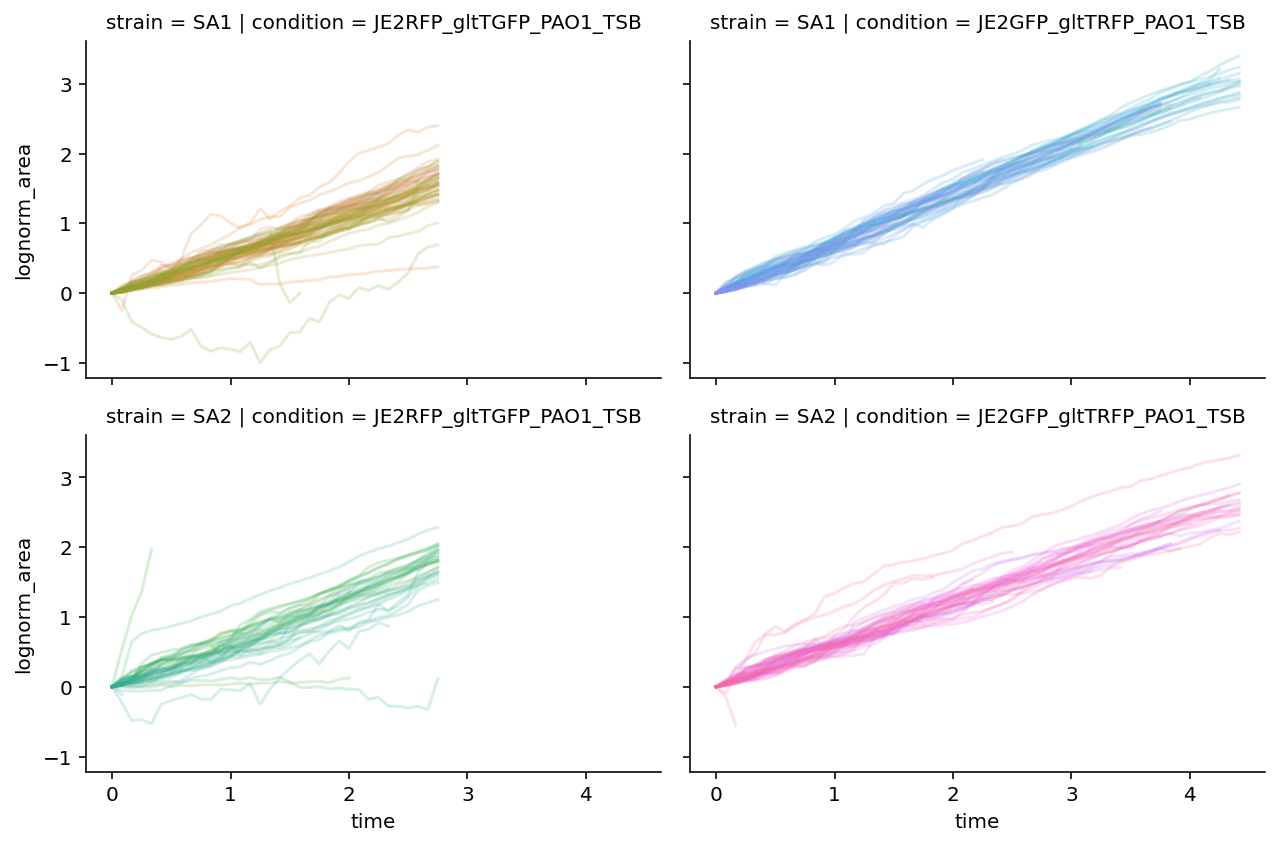

In [137]:
#filter out PA and untracked colonies
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['colony_id']>=0)].copy()

#add unique id
unique_id = df['strain'].map(str) + '-' + df['pos'].map(str) + '-' + df['colony_id'].map(str)  
df['unique_id'] = unique_id

#add time in hours
df['time'] = df['frame']*dt_frames

# add normalized area
df['area'] = df['area'].astype(float)
df['lognorm_area'] = np.log(df['area'].div(df.groupby('unique_id')['area'].transform('first')))
df['log_area_change'] = df.groupby('unique_id')['lognorm_area'].diff(1)

#plot log normalized area
g = sns.FacetGrid(data=df, col='condition',row='strain',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='time', y='lognorm_area', alpha=0.2)

### Filter out miss-tracked colonies

We see there are some weird trajectories which we need to remove.

We do automatic filtering by calculate the log length change between two frames and cutting trajectories when this becomes too big or small

(-0.2, 0.3)

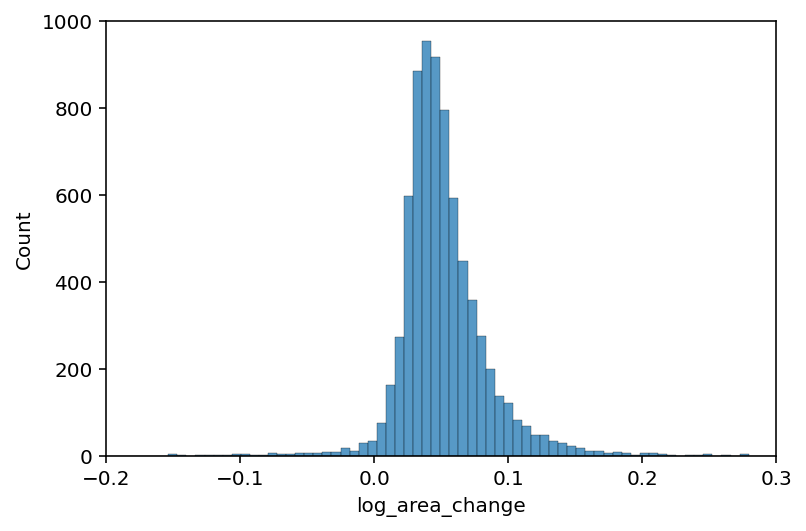

In [138]:
sns.histplot(data=df, x='log_area_change', bins=200).set_xlim(-0.2,0.3)

Based on histogram we can set max change in length (corresponds to max growth rate) and plot the resulting filtered data

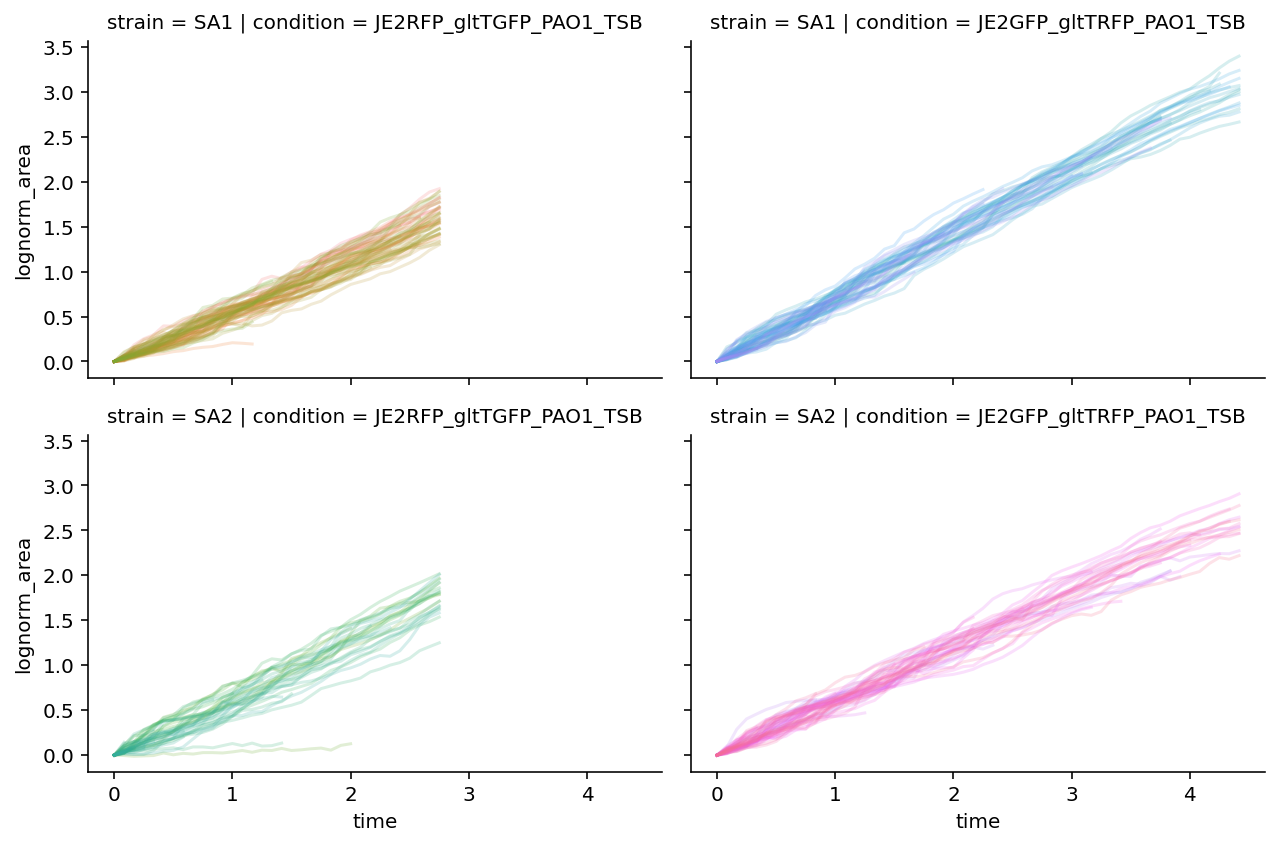

In [139]:
#set min and max change in log area between frames for filtering
min_dl = -0.06
max_dl = 0.2

#stop tracks at first frame where error occurs
df['track_error'] = (df['log_area_change']<min_dl) | (df['log_area_change']>max_dl)
track_filter = df.groupby('unique_id')['track_error'].cumsum() > 0
df_filtered = df.loc[~track_filter].copy()

#plot filtered data
g = sns.FacetGrid(data=df_filtered, col='condition',row='strain',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='time', y='lognorm_area', alpha=0.2)

Let's check how many colonies we can track as function of time:

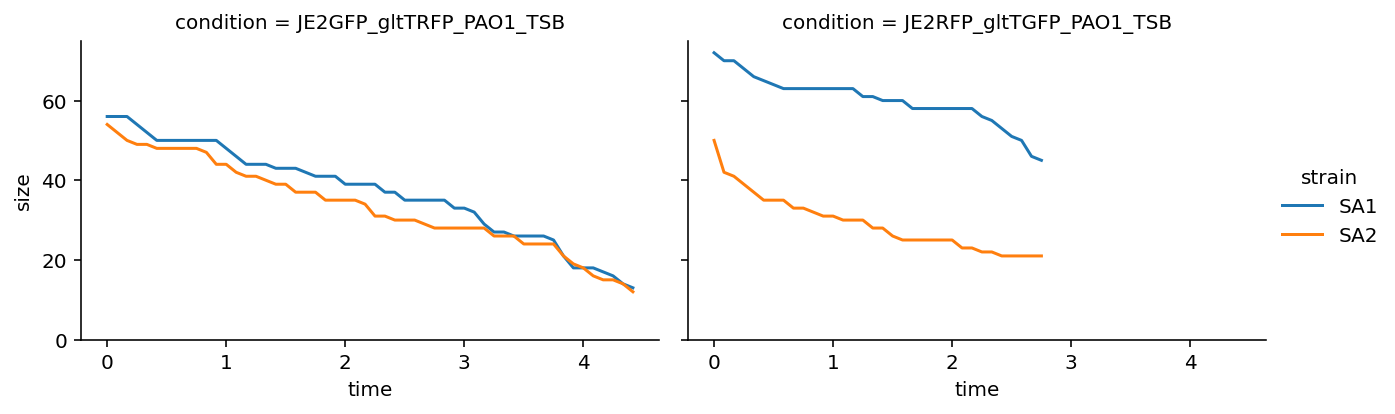

In [141]:
col_num_t = df_filtered.groupby(['strain','frame','time','condition'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, col='condition',hue='strain',aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='size').add_legend()
g.set(ylim=(0, None))

---

## 3. Analyze growth rate over time

Now that we have clean trajectories we can calculate the growth rates, by using a moving window to locally fit the log-area.
This gives the growth rate of the colony as function of time

In [162]:
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

fit_window = 11
df_filtered['mu'] = df_filtered.groupby('unique_id')['area'].rolling(fit_window, min_periods=6, center=True).apply(derivative, kwargs={'frm_interval':dt_frames, 'log':True}).reset_index(0,drop=True)

### 3.1 Colony growth rate as function of time

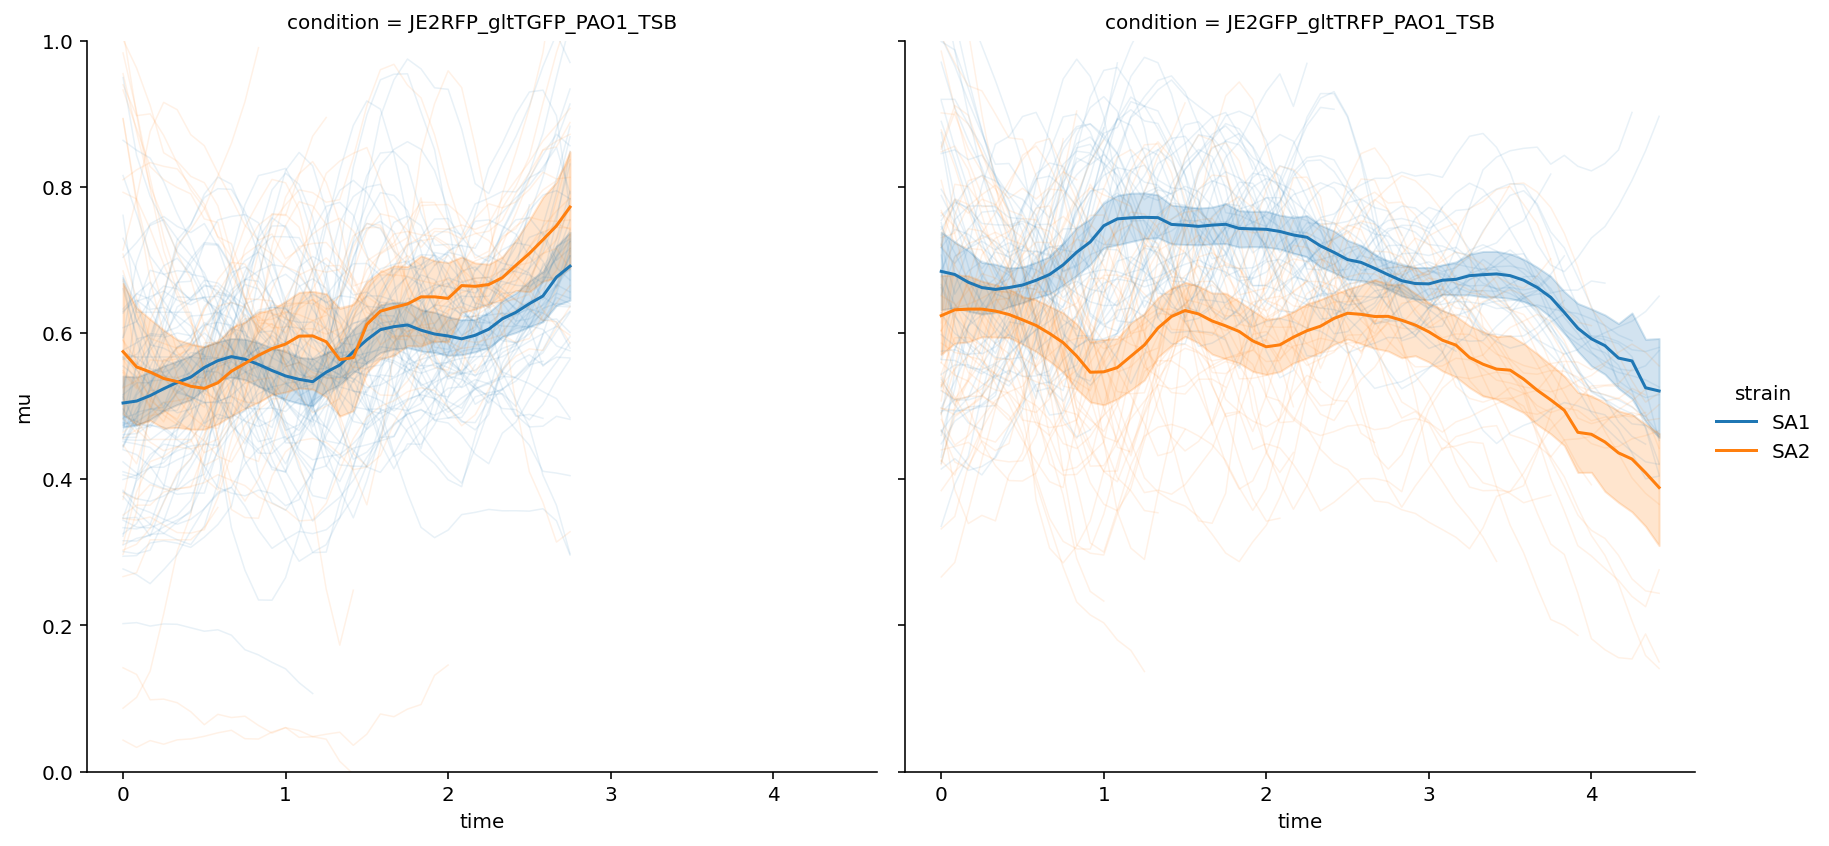

In [164]:
g = sns.FacetGrid(data=df_filtered, col='condition',hue='strain',aspect=1,height=6)
g.map_dataframe(sns.lineplot, x='time', y='mu', alpha=0.1,size=1,units='unique_id', estimator=None)
g.map_dataframe(sns.lineplot, x='time', y='mu').add_legend()

g.set(ylim=(0, 1))

### 3.2 Instantaneous growth rate vs Instantaneous distance to PA

We now plot the instantaneous growth rate of SA as function of the centre-to-centre distance to the nearest PA colony.

Note that each colony gives multiple statistically-dependent data-points (the growth rate is fitted over overlapping time windows).

Take care when doing statistical analysis on this data!

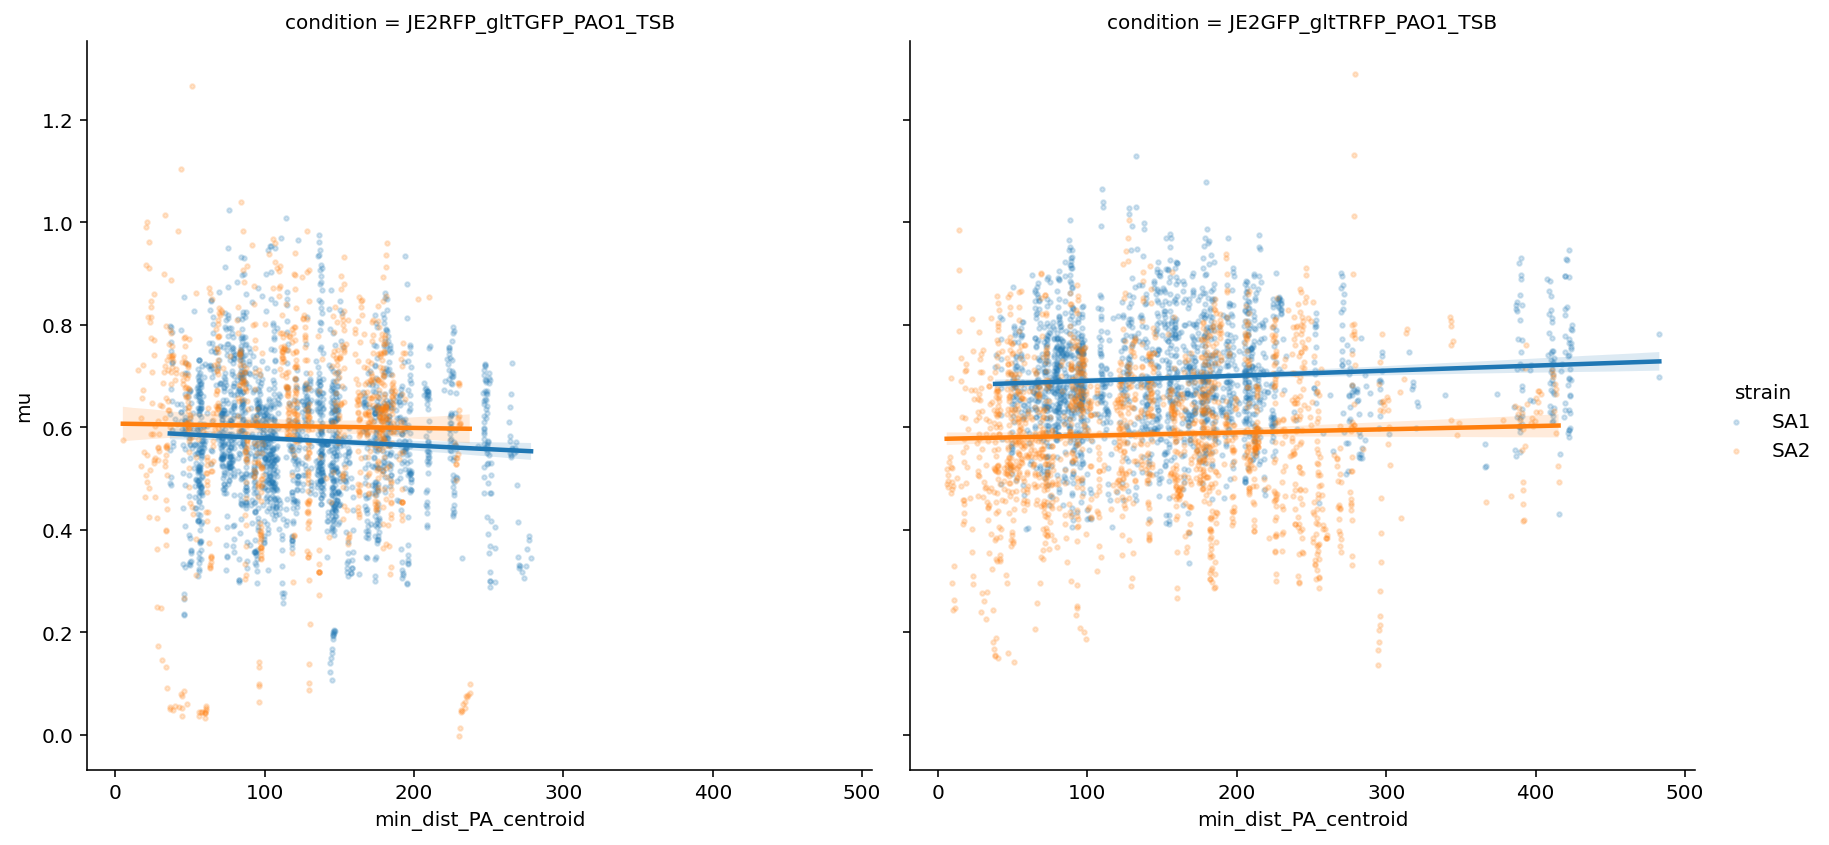

In [165]:
sns.lmplot(data=df_filtered, x='min_dist_PA_centroid', y='mu', col='condition', hue='strain', scatter_kws={'s':5,'alpha':0.2}, aspect=1, height=6)

## 4. Analyze growth rate over longer time periods

To avoid statistical dependence between data points we now calculate a single growth rate per colony, defined as `mu= log(area[t]/area[0])) / dt` where `area[t]` is the colony area after a defined time `t` and `area[0]` is the area at the start of the movie. We check a number of different values of `t` below.

In [168]:
#set time points to analyze
t_analyze = [20, 30, 40, 50]

def summary_stats(x, period=10):
    '''create summary stats for each colony
    
    Parameters
    ----------
    x : pandas dataframe
        dataframe with colony data
    period : int
        number of frames to calculate stats over
    
    Returns
    -------
    d : Pandas Series
        Pandas series with summary stats
    '''
    
    #calculate growth rate
    start_area = x['area'].iloc[0]    
    end_area = x['area'].iloc[period] if x['area'].size > period else np.nan
    growth = np.log(end_area/start_area) / period

    d = {}
    d['centroid-0_av'] = x['centroid-0'].mean()
    d['centroid-1_av'] = x['centroid-1'].mean()
    d['dist_PA_centroid_av'] = x['min_dist_PA_centroid'].mean()
    d['dist_PA_centroid_min'] = x['min_dist_PA_centroid'].min()
    d['dist_PA_centroid_start'] = x['min_dist_PA_centroid'].iloc[0]
    d['strain'] = x['strain'].iloc[0]
    d['condition'] = x['condition'].iloc[0]
    d['colony_id'] = x['colony_id'].iloc[0]
    d['unique_id'] = x['unique_id'].iloc[0]
    d['area_start'] = start_area
    d['area_end'] = end_area
    d['growth'] = growth
    
    d['period' ] = period
        
    index = ['period','centroid-0_av', 'centroid-1_av', 'dist_PA_centroid_av', 'dist_PA_centroid_min', 'dist_PA_centroid_start', 'strain', 'condition', 'colony_id', 'unique_id', 'area_start', 'area_end', 'growth']

    return pd.Series(d, index=index)

#create summary stats for each colony
dfList = [df_filtered.groupby('unique_id').apply(summary_stats, period=period).reset_index(drop=True) for period in t_analyze]
df_summary = pd.concat(dfList, axis=0, ignore_index=True)

We can now plot the colony growth rate (measured at different times) as function as the minimal distance to PA.

The distance between SA and PA colonies changes with time, we deal with this below by checking how growth rate correlates with the initial, minimal, and average distance (over time) to the nearest PA colony.

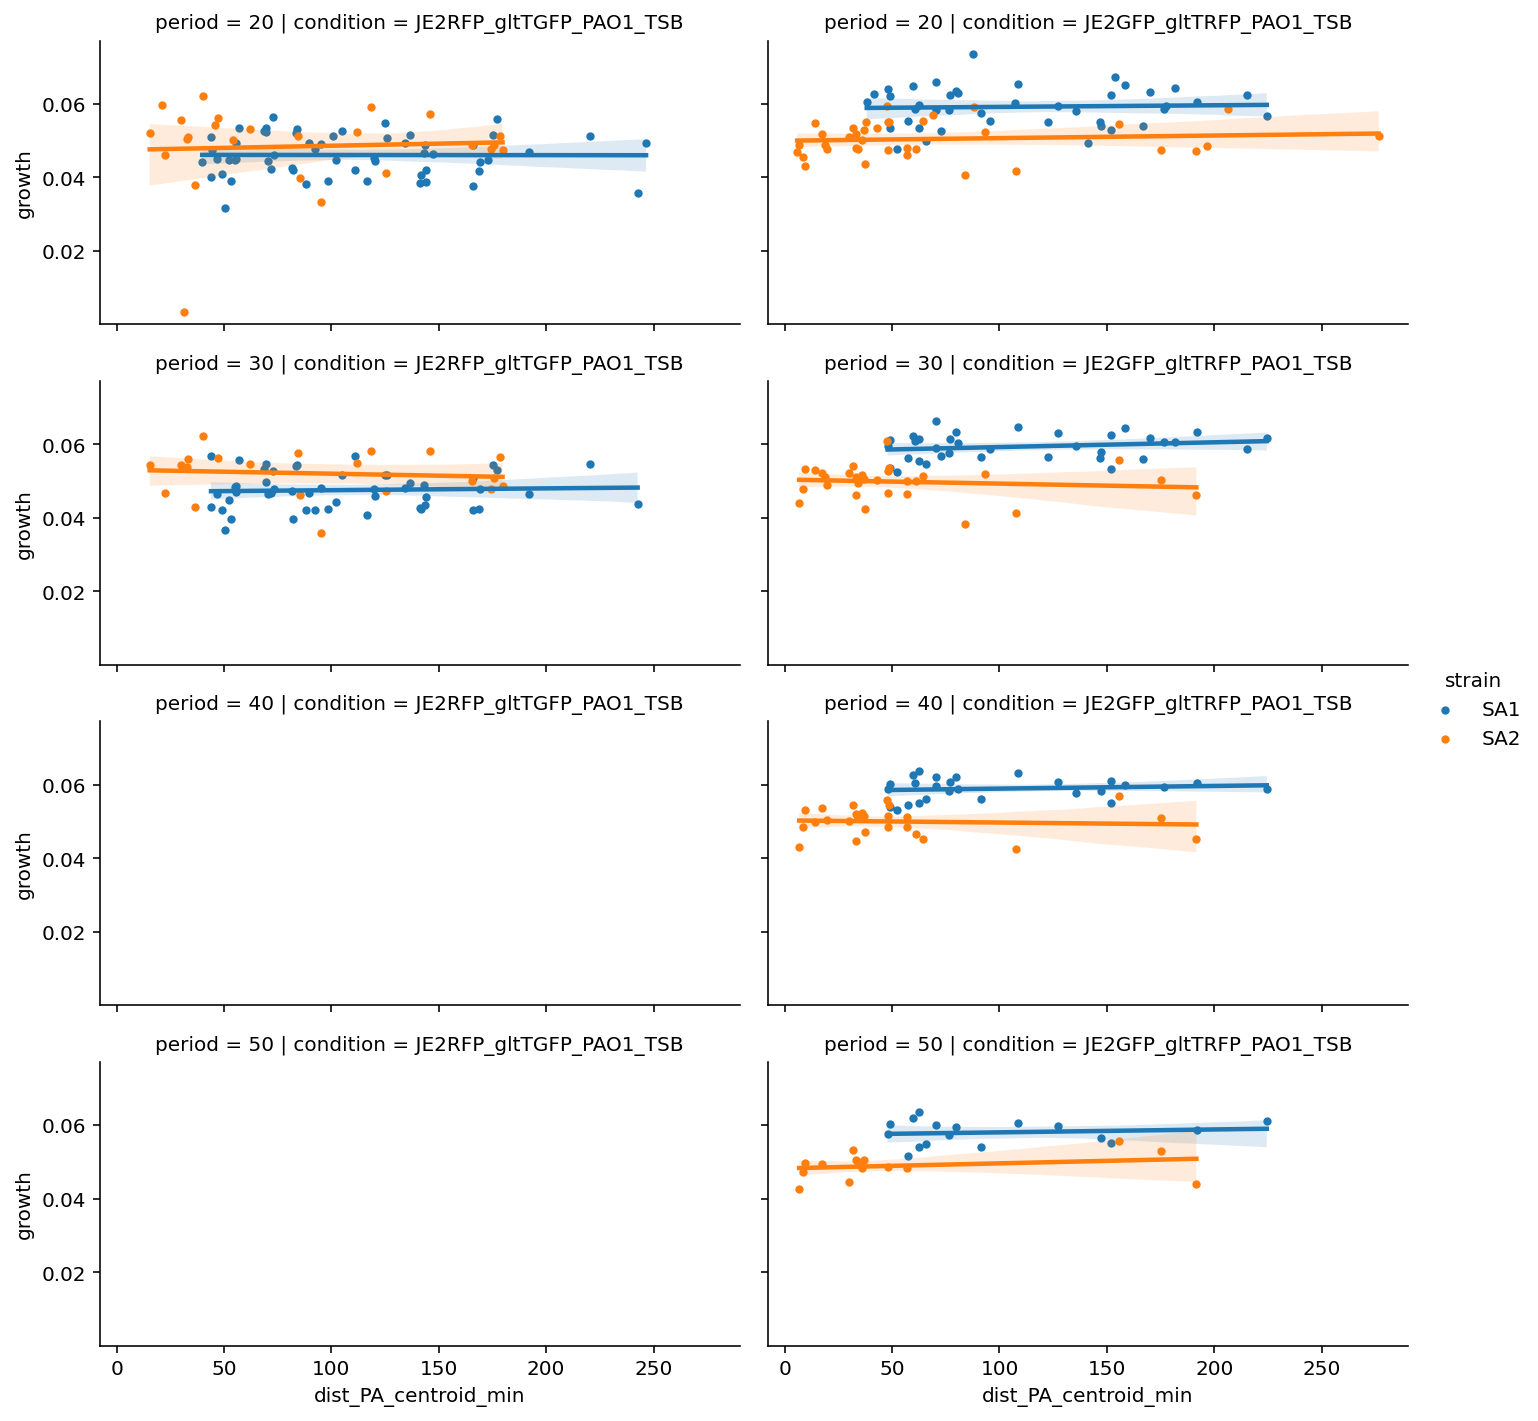

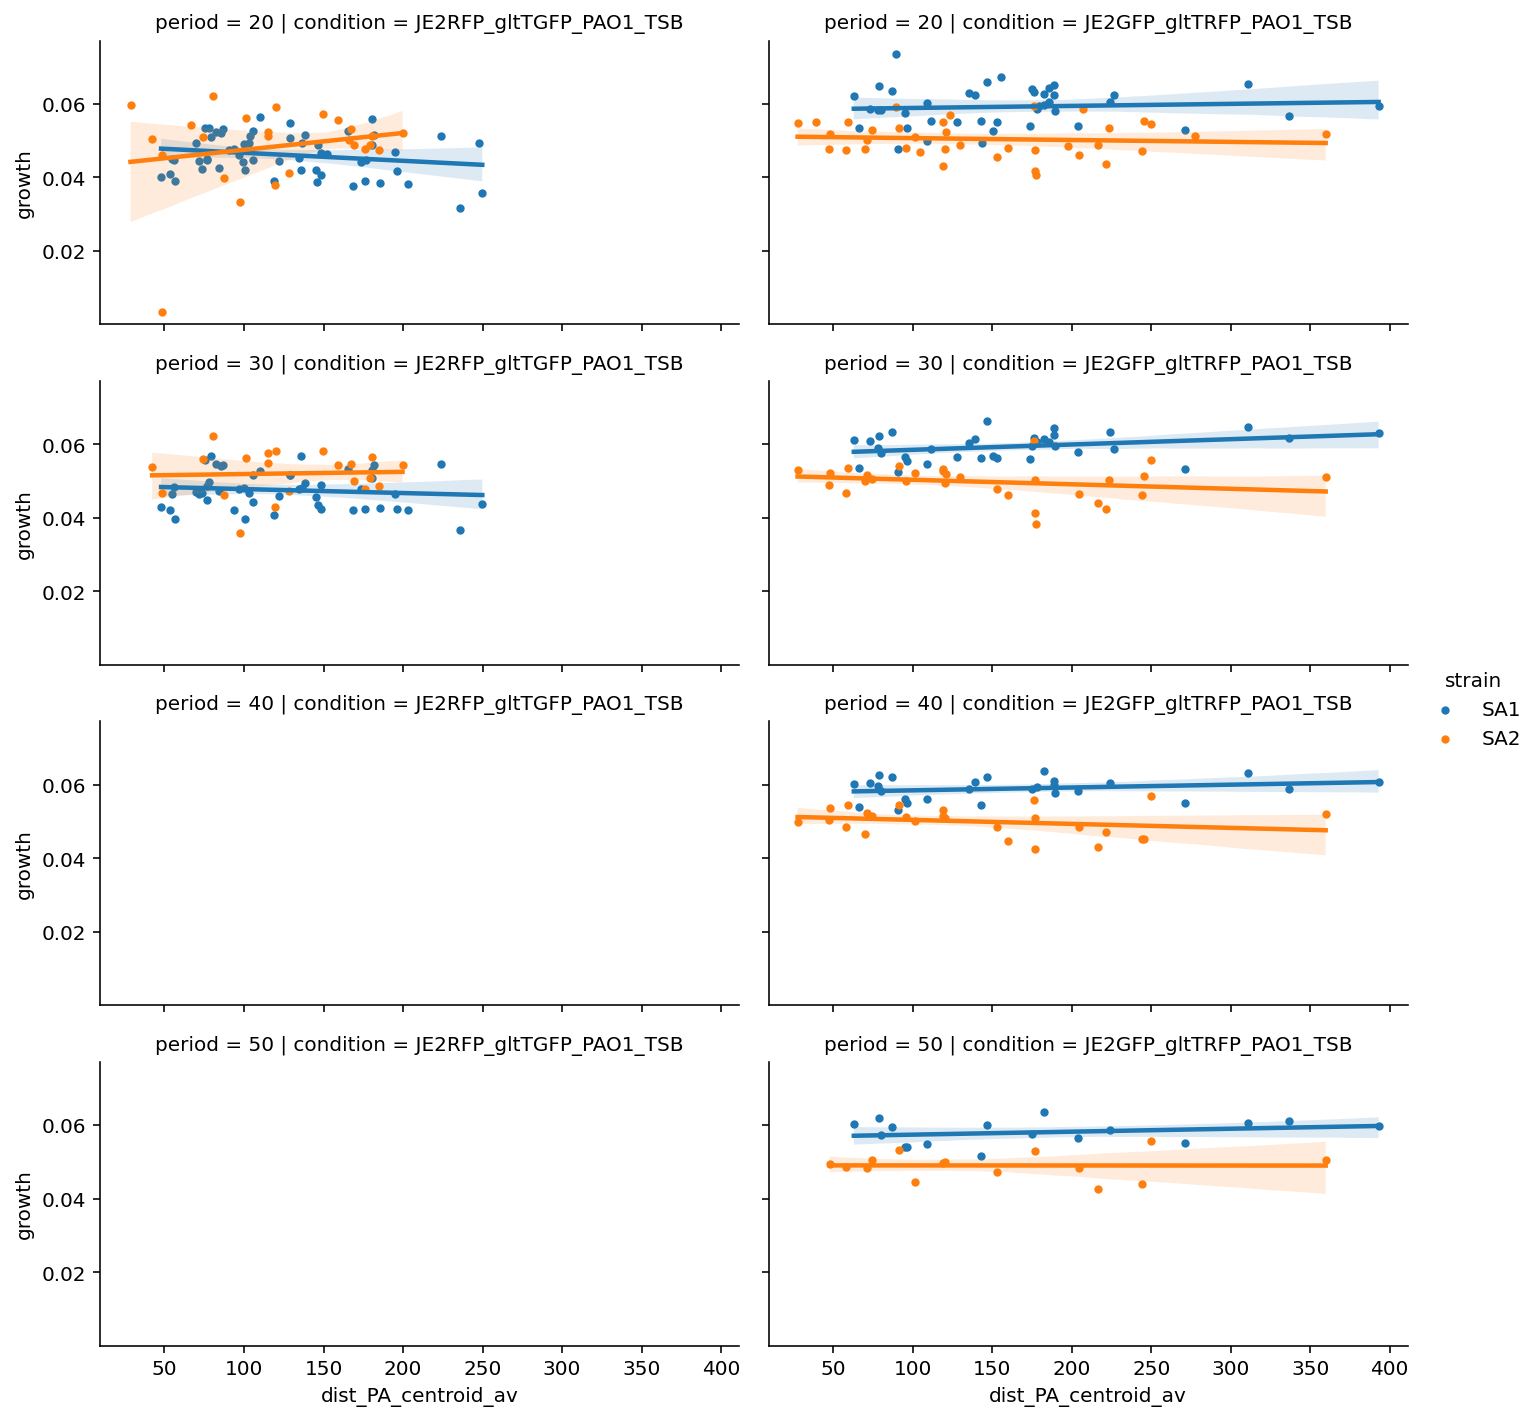

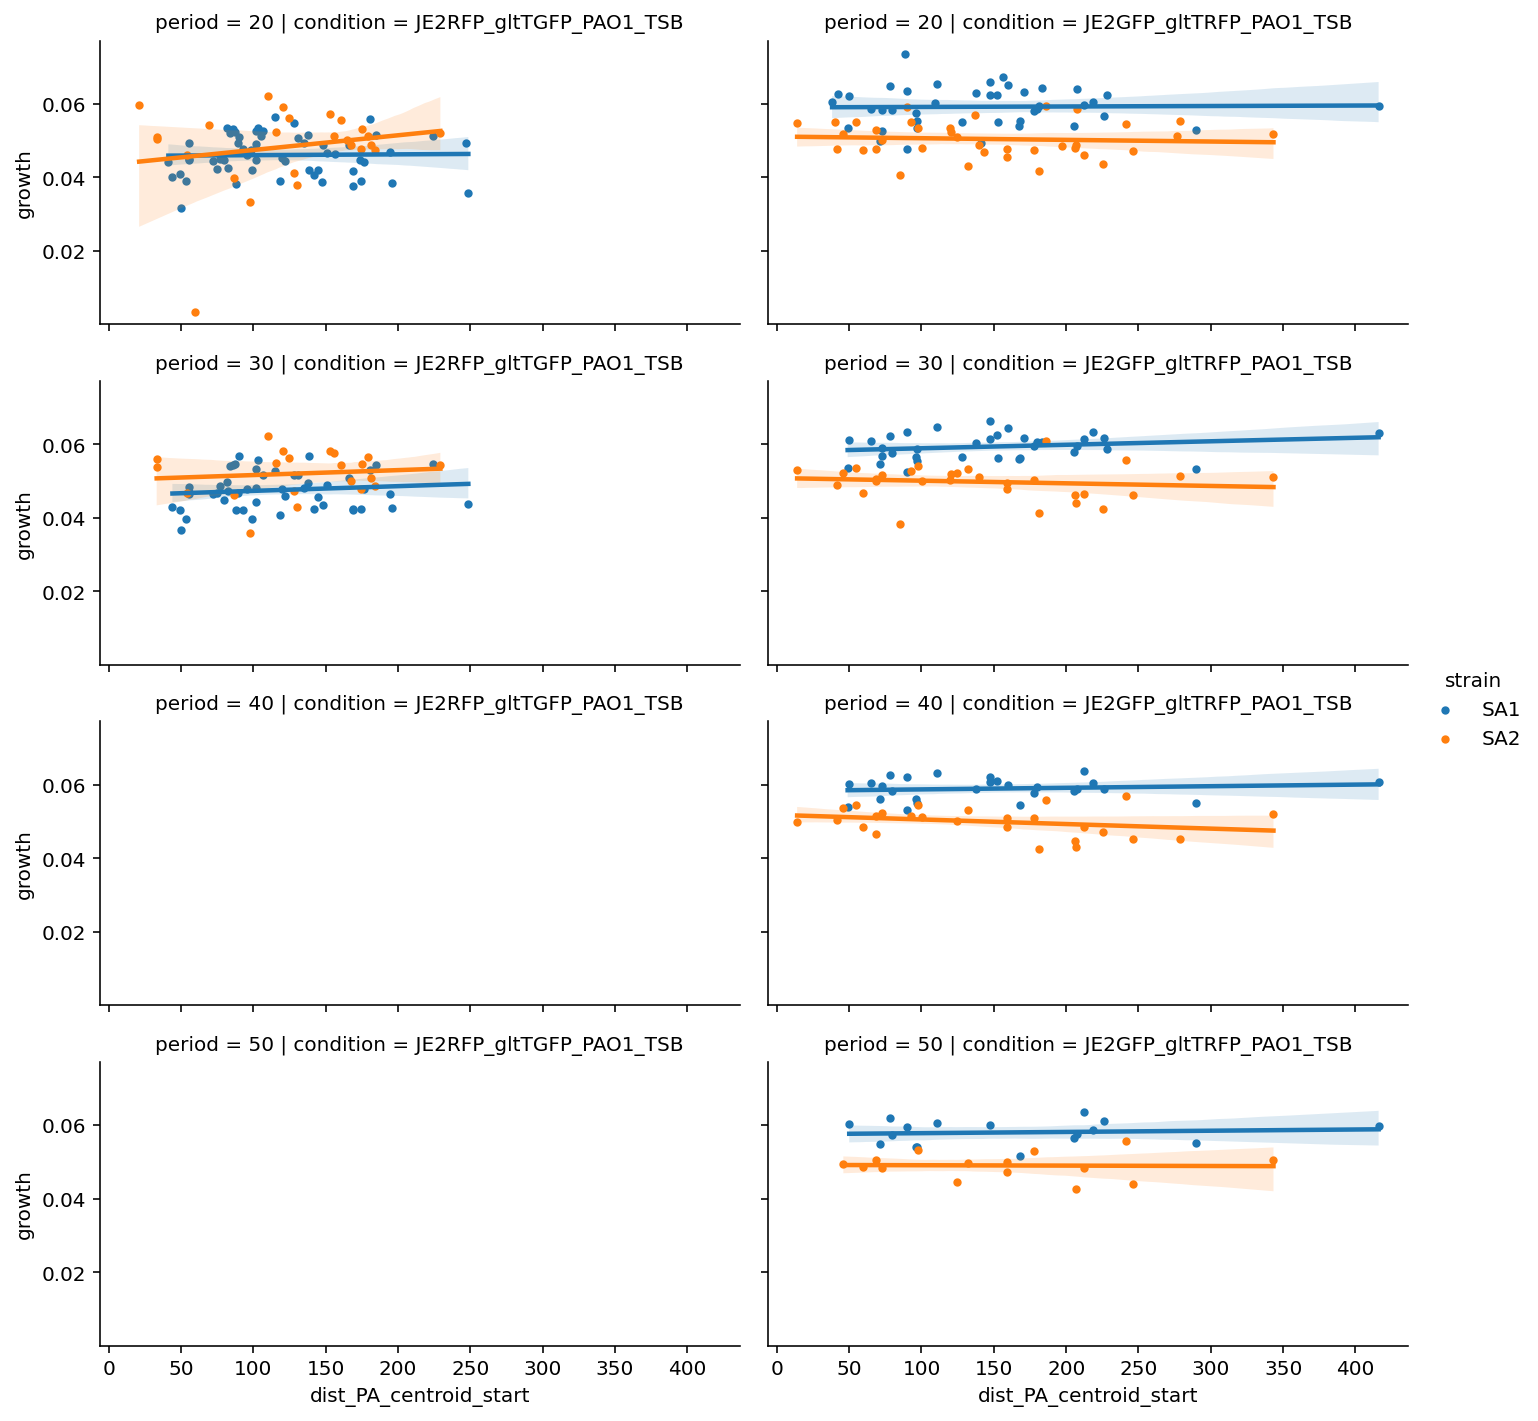

In [169]:
sns.lmplot(data=df_summary, x='dist_PA_centroid_min', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)

sns.lmplot(data=df_summary, x='dist_PA_centroid_av', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)

sns.lmplot(data=df_summary, x='dist_PA_centroid_start', y='growth', col='condition', row='period',hue='strain', scatter_kws={'s':10,'alpha':1}, aspect=2, height=2.5)